# Method descriptions

* **centralized** finds global classifier using the centralized data
* Average local classifiers between neighbors
  * **avg-unweighted** all the edges have the same value
  * **avg-weighted** algorithm weights an edge as the *similarity* between the two nodes *times* the *number of instances* of the neighbor (normalized)
* **regularised** learns local classifiers keeping them similar to the neighbors' classifiers
* **local** learns independent local classifiers


In [1]:
# imports
from copy import deepcopy
import numpy as np

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from evaluation import clf_variance, central_accuracy, central_loss, accuracies
from network import line_network, synthetic_graph, true_theta_graph
from related_works import colearning
from optimization import centralized_FW, async_regularized_local_FW, regularized_local_FW, local_FW, global_regularized_local_FW
from utils import generate_models, generate_moons

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 50
N = 100
D = 20
NOISE_R = 0.05
random_state = 2017
MU = 0.1

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=N, random_state=random_state)
_, X, Y, X_test, Y_test, _, _ = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []]
}

In [3]:
results = {}

nodes_copy = deepcopy(nodes)
results["centralized"] = centralized_FW(nodes_copy, D, NB_ITER, callbacks=callbacks)

nodes_regularized = deepcopy(nodes)
results["regularized"] = regularized_local_FW(nodes_regularized, D, NB_ITER, mu=0.1, callbacks=callbacks)

# nodes_copy = deepcopy(nodes)
# results["async_regularized"] = async_regularized_local_FW(nodes_copy, D, NB_ITER, mu=0.1, callbacks=callbacks)

nodes_copy = deepcopy(nodes)
results["local"] = local_FW(nodes_copy, D, NB_ITER, callbacks=callbacks)

nodes_copy = deepcopy(nodes)
results["global-reg"] = global_regularized_local_FW(nodes_copy, D, NB_ITER, callbacks=callbacks)

# colearning results
results["colearning"], clf_colearning = colearning(N, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities)

# get results with true thetas
true_graph = true_theta_graph(nodes_copy, theta_true)
acc = central_accuracy(true_graph)

print("done")

done


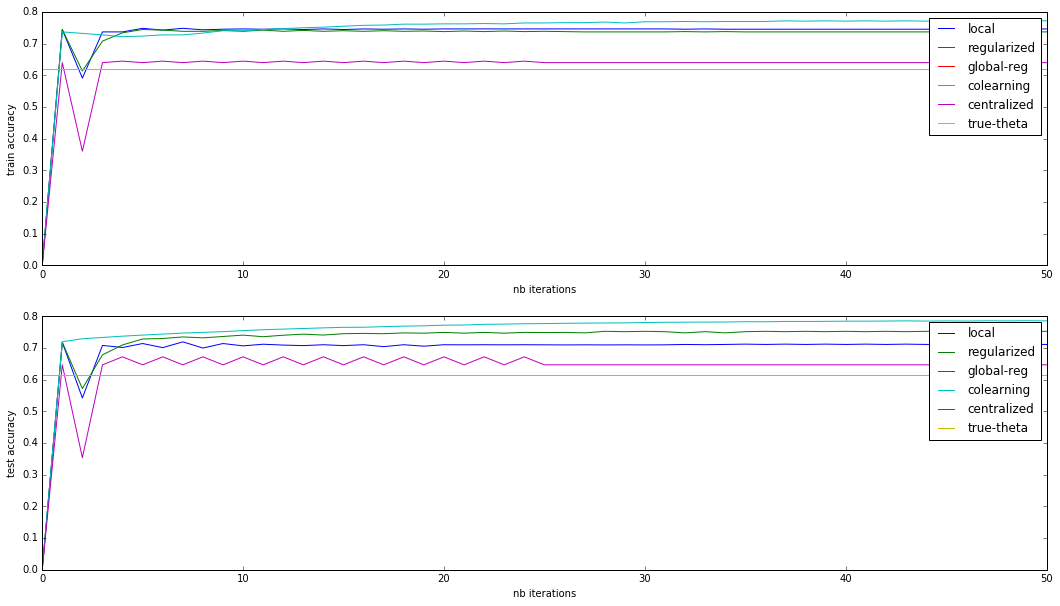

In [4]:
plt.figure(1, figsize=(18, 10))

plt.subplot(211)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
# add results of true thetas
plt.plot(range(len(r_list)), [acc[0]]*len(r_list), label='true-theta')
plt.legend()

plt.subplot(212)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [acc[1]]*len(r_list), label='true-theta')
plt.legend()

### Visualize classification


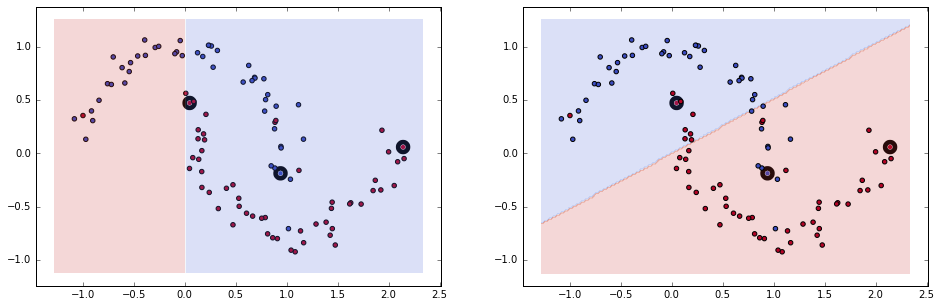

In [8]:
NODE = 99

plt.figure(1, figsize=(16, 5))
# our method
plt.subplot(121)

# training data
X = nodes_regularized[NODE].sample
Y = nodes_regularized[NODE].labels

X_test = nodes_regularized[NODE].test_sample
Y_test = nodes_regularized[NODE].test_labels

# construct grid
x_min,x_max = X_test[:,0].min() - 0.2, X_test[:,0].max() + 0.2
y_min, y_max = X_test[:,1].min() - 0.2, X_test[:,1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# expand dimensions
grid_set = np.c_[xx.ravel(), yy.ravel()]
grid_set = np.hstack((grid_set, np.zeros((len(grid_set), D - 1))))
y = nodes_regularized[0].predict(grid_set).reshape(xx.shape)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.coolwarm, linewidths=10)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap=plt.cm.coolwarm)

plt.contourf(xx, yy, y, cmap=plt.cm.coolwarm, alpha=0.2)

# colearning
plt.subplot(122)

# training data
X = nodes_regularized[NODE].sample
Y = nodes_regularized[NODE].labels

grid_set = np.c_[xx.ravel(), yy.ravel()]
grid_set = np.hstack((grid_set, np.zeros((len(grid_set), D - 2))))
y = np.sign(np.inner(grid_set, clf_colearning[NODE, :])).reshape(xx.shape)

plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.coolwarm, linewidths=10)
plt.contourf(xx, yy, y, cmap=plt.cm.coolwarm, alpha=0.2)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test, cmap=plt.cm.coolwarm)